In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
#import tqdm
from tqdm import tqdm_notebook as tqdm

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

In [2]:
def load_files(path):
    train_labels = os.listdir(PATH)
    train_labels.remove('_background_noise_')
  
    train_files_labels =[]
 
    for label in train_labels:
        files = os.listdir(PATH + '/' + label)
        for f in files:
            train_files_labels.append([PATH + label + '/' + f, label])
      
      
      
    train_files_labels = np.array(train_files_labels)

    return train_files_labels

In [3]:
PATH = 'data/train/audio/'

In [4]:
data = load_files(PATH)

In [5]:
samples_rate = np.array([wavfile.read(i)[0] for i in tqdm(data[:,0])])
samples = np.array([wavfile.read(i)[1].astype(float) for i in tqdm(data[:,0])])
labels = data[:,1]

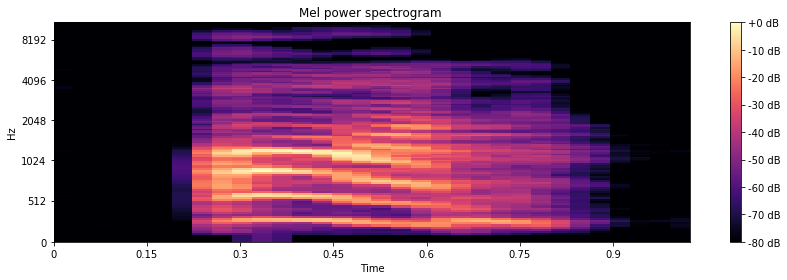

In [9]:
S = librosa.feature.melspectrogram(samples[1], sr=samples_rate[1], n_mels=128)

log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=samples_rate[1], x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

/home/shared/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



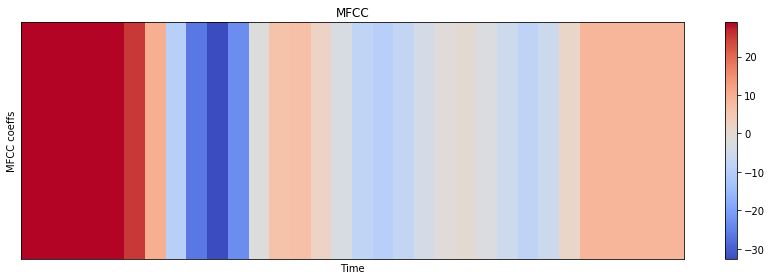

In [10]:
mfcc = librosa.feature.mfcc(y=samples[1], n_mfcc=1)
delta_mfcc = librosa.feature.delta(mfcc, order=1)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [11]:
num_of_shorter = 0
for sample in samples:
    if sample.shape[0] < 16000:
                num_of_shorter += 1
print('`Number of recordings shorter than 1 second: ' + str(num_of_shorter))

`Number of recordings shorter than 1 second: 6469


### padding with zero to make all length equal to 16000

In [12]:
samples_eq = np.array([np.pad(sample, (0,16000-sample.shape[0]), 'constant') for sample in tqdm(samples)])

### Feature extraction:
Extracting delta and delta2 from MFCC, concatenate them to make an array with length of 64 for each sample.

In [ ]:
X=[]
for sample in tqdm(samples_eq):
    mfcc = librosa.feature.mfcc(y=sample, n_mfcc=1) 
    delta_mfcc = librosa.feature.delta(mfcc, order=1)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    X.append([np.concatenate((delta_mfcc[0,:],delta2_mfcc[0,:]))])
X = np.vstack(X)

/home/shared/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



In [14]:
X.shape

(64721, 64)

#### Label Encoding:
Converting string labels to categorical numbers:

In [27]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
y = le.transform(labels)
le.classes_

array(['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go',
       'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on',
       'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
       'two', 'up', 'wow', 'yes', 'zero'], dtype='<U45')

Converting categorical numbers to one hot sequence:

In [28]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(y.reshape(-1, 1))
y = enc.transform(y.reshape(-1, 1)).toarray()

In [29]:
y [1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [30]:
number_of_classes = len(y[1])
number_of_classes

30

##### Splitting data to "Train" and "Test" sets. 20% / 80%

In [38]:
y_train.shape

(51776, 30)

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Building NN:

In [70]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import multi_gpu_model

In [71]:
model = Sequential()
model.add(LSTM(32,  return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(Dense(number_of_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                990       
Total params: 5,342
Trainable params: 5,342
Non-trainable params: 0
_________________________________________________________________


In [72]:
parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [73]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [74]:
history = parallel_model.fit(X_train, y_train, batch_size=128,
                           epochs=10, verbose=1,
                           validation_split=0.2)

Train on 41420 samples, validate on 10356 samples
Epoch 1/10
41420/41420 [==============================] - 86s 2ms/step - loss: 3.3209 - acc: 0.0567 - val_loss: 3.1784 - val_acc: 0.0817
Epoch 2/10
41420/41420 [==============================] - 83s 2ms/step - loss: 3.1292 - acc: 0.0896 - val_loss: 3.0625 - val_acc: 0.1053
Epoch 3/10
41420/41420 [==============================] - 83s 2ms/step - loss: 3.0290 - acc: 0.1154 - val_loss: 2.9651 - val_acc: 0.1354
Epoch 4/10
41420/41420 [==============================] - 83s 2ms/step - loss: 2.9546 - acc: 0.1346 - val_loss: 2.9081 - val_acc: 0.1531
Epoch 5/10
41420/41420 [==============================] - 83s 2ms/step - loss: 2.9052 - acc: 0.1499 - val_loss: 2.8633 - val_acc: 0.1653
Epoch 6/10
41420/41420 [==============================] - 83s 2ms/step - loss: 2.8687 - acc: 0.1590 - val_loss: 2.8311 - val_acc: 0.1675
Epoch 7/10
41420/41420 [==============================] - 83s 2ms/step - loss: 2.8358 - acc: 0.1672 - val_loss: 2.8027 - val_acc

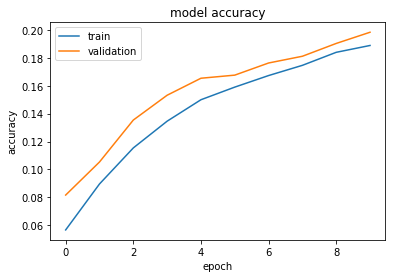

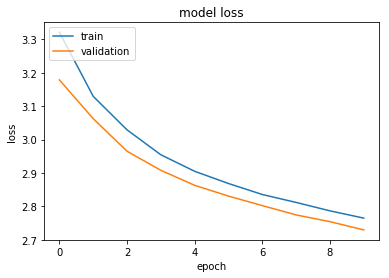

In [75]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [76]:
history = parallel_model.fit(X_train, y_train, batch_size=128,
                           epochs=10, verbose=0,
                           validation_split=0.2)

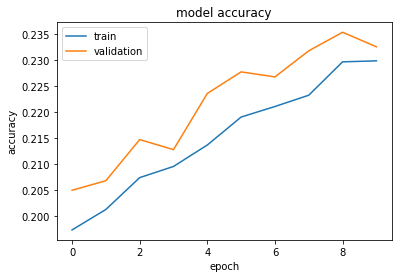

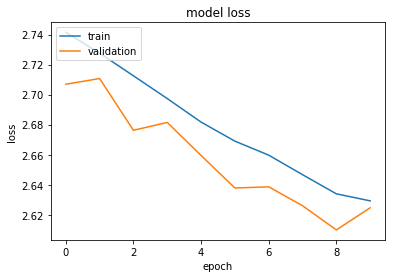

In [77]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()